## TOC:
* [Set-up](#Set-up)
* [Preprocessing](#2)
* [Feature Engineering](#3)
* [Data Cleaning](#4)
* [Preperation for Model](#5)

## Set-up <a class="anchor" id="Set-up"></a>

In [467]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV
import re
from collections import Counter

In [468]:
df = pd.read_csv('/Users/noahcampana/Desktop/Studium/Master/Semester 1/Machine Learning/Project/project_data/train.csv', index_col = 'encounter_id')
df.head()

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
533253,USA,70110,Caucasian,Female,[70-80),?,?,0,0,2,...,276,466,8,NaN,NaN,No,No,[],No,>30 days
426224,USA,29775006,AfricanAmerican,Male,[50-60),?,?,0,0,0,...,785,162,9,NaN,NaN,No,Yes,['insulin'],No,No
634063,USA,80729253,Caucasian,Female,[60-70),?,?,0,0,1,...,135,250,6,NaN,NaN,Ch,Yes,"['glimepiride', 'insulin']",No,No
890610,USA,2919042,AfricanAmerican,Male,[60-70),?,MC,0,0,1,...,562,455,5,NaN,NaN,No,No,[],No,No
654194,USA,84871971,Caucasian,Female,[70-80),?,HM,1,0,0,...,599,428,9,NaN,NaN,No,No,[],No,>30 days


## Preprocessing <a class="anchor" id="2"></a>

In [469]:
df.replace("", np.nan, inplace=True)
df.replace("?", np.nan, inplace=True)

df['change_in_meds_during_hospitalization'] = df['change_in_meds_during_hospitalization'].map({'Ch': 1, 'No': 0})
df['change_in_meds_during_hospitalization'] = df['change_in_meds_during_hospitalization'].astype(bool)

df['prescribed_diabetes_meds'] = df['prescribed_diabetes_meds'].map({'Yes': 1, 'No': 0})
df['prescribed_diabetes_meds'] = df['prescribed_diabetes_meds'].astype(bool)

# Drop COUNTRY column
df = df.drop(columns=['country'])

# Drop WEIGHT column
df = df.drop(columns=['weight'])
#--------------------------------------------------------------

# Make GENDER to boolean
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df.rename(columns={'gender': 'is_male'}, inplace=True)
df['is_male'] = df['is_male'].astype(bool)

# Handle missing RACE values
# Identify rows with missing 'race' values
missing_race_rows = df[df['race'].isna()]

# Filter rows of patients who visited more than once and have at least one non-missing 'race' value
potential_fill_rows = df[df['patient_id'].isin(missing_race_rows['patient_id']) & df['race'].notna()]

# Find the number of missing 'race' values that can potentially be filled
fillable_values = potential_fill_rows['patient_id'].nunique()

# Now we are filling the missing values
race_dict = dict(zip(potential_fill_rows['patient_id'], potential_fill_rows['race']))
df['race'] = df.apply(
    lambda row: race_dict[row['patient_id']] if pd.isna(row['race']) and row['patient_id'] in race_dict else row['race'], axis=1)

df['race'].fillna('Other', inplace=True)


# Handle missing values of DIAGNOSIS
df['primary_diagnosis'].fillna(df['primary_diagnosis'].mode()[0], inplace=True)
df['secondary_diagnosis'].fillna(df['secondary_diagnosis'].mode()[0], inplace=True)

# Create a label encoder
label_encoder = LabelEncoder()

df_copy = df.copy()
# Apply label encoding to 'primary_diagnosis' and 'secondary_diagnosis'
df_copy['primary_diagnosis'] = label_encoder.fit_transform(df['primary_diagnosis'])
df_copy['secondary_diagnosis'] = label_encoder.fit_transform(df['secondary_diagnosis'])

# Now, 'primary_diagnosis' and 'secondary_diagnosis' have been encoded as numerical values

# Separate the dataset into parts with and without missing 'additional_diagnosis'
df_with_missing = df_copy[df_copy['additional_diagnosis'].isna()]
df_without_missing = df_copy[~df_copy['additional_diagnosis'].isna()]

# Define the features and target for the classification model
X = df_without_missing[['primary_diagnosis', 'secondary_diagnosis']]
y = (df_without_missing['additional_diagnosis'].notna()).astype(int)

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classification model (e.g., RandomForest)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Use the trained model to predict if 'additional_diagnosis' is present for the part with missing values
X_predict = df_with_missing[['primary_diagnosis', 'secondary_diagnosis']]
y_predict = clf.predict(X_predict)

# Update the missing 'additional_diagnosis' values based on predictions
df.loc[df['additional_diagnosis'].isna(), 'additional_diagnosis'] = y_predict
#-----------------------------------------------------------------------------

# Handle AGE column (same approach as race)
# AGE 
df['age'] = df.apply(
    lambda row: age_dict[row['patient_id']] if pd.isna(row['age']) and row['patient_id'] in age_dict else row['age'], axis=1)

df['age'].fillna(df['age'].mode()[0], inplace=True)
age_mapping = {
    '[0-10)': 5,
    '[10-20)': 15,
    '[20-30)': 25,
    '[30-40)': 35,
    '[40-50)': 45,
    '[50-60)': 55,
    '[60-70)': 65,
    '[70-80)': 75,
    '[80-90)': 85,
    '[90-100)': 95
}
df['age'] = df['age'].replace(age_mapping)

missing_age_rows = df[df['age'].isna()]

# Filter rows of patients who visited more than once and have at least one non-missing 'age' value
potential_fill_rows = df[df['patient_id'].isin(missing_age_rows['patient_id']) & df['age'].notna()]

#now we are filling the missing values
age_dict = dict(zip(potential_fill_rows['patient_id'], potential_fill_rows['age']))
#------------------------------------------------------------------------------

# ADMISSION SOURCE --> mode
mode_admission_source = df['admission_source'].mode()[0]
df['admission_source'].fillna(mode_admission_source, inplace=True)

# ADMISSION TYPE --> mode
mode_admission_source = df['admission_type'].mode()[0]
df['admission_type'].fillna(mode_admission_source, inplace=True)

# MEDICAL SPECIALITY --> mode
mode_specialty = df['medical_specialty'].mode()[0]
df['medical_specialty'].fillna(mode_specialty, inplace=True)

# DISCHARGE DISPOSITION --> mode
mode_discharge = df['discharge_disposition'].mode()[0]
df['discharge_disposition'].fillna(mode_discharge, inplace=True)

# GLUCOSE TEST --> "None"
df['glucose_test_result'].fillna('None', inplace=True)

# A1C Test --> "None"
df['a1c_test_result'].fillna('None', inplace=True)

# PAYER CODE --> fill "No"
df['payer_code'].fillna('No', inplace=True)
df['payer_code'] = df['payer_code'].apply(lambda x: False if x == 'No' else True)
df['payer_code'] = df['payer_code'].astype(bool)
df.rename(columns={'payer_code': 'has_insurance'}, inplace=True)

## Feature Engineering <a class="anchor" id="3"></a>

In [470]:
# ADMISSION TYPE
df['admission_type'] = df['admission_type'].replace(['Newborn', 'Trauma Center'], df['admission_type'].mode().iloc[0])
df['admission_type'] = df['admission_type'].replace(['Not Available', 'Not Mapped'], df['admission_type'].mode().iloc[0])

# ADMISSION SOURCE
df['admission_source'] = df['admission_source'].replace([' Sick Baby', 'Normal Delivery', ' Extramural Birth', 
                                                             ' Court/Law Enforcement'], df['admission_source'].mode().iloc[0])
df.loc[df['admission_source'].isin([' Physician Referral', 'Clinic Referral', 'HMO Referral']), 'admission_source'] = 'Referral'
df.loc[df['admission_source'].isin(['Transfer from a hospital', ' Transfer from another health care facility', \
                                        ' Transfer from a Skilled Nursing Facility (SNF)', \
                                       ' Transfer from hospital inpt/same fac reslt in a sep claim', \
                                       ' Transfer from critial access hospital', \
                                       ' Transfer from Ambulatory Surgery Center']), 'admission_source'] = 'Transfer'
df['admission_source'] = df['admission_source'].replace([' Not Mapped','Not Available'], df['admission_source'].mode().iloc[0])
df['admission_source'] = df['admission_source'].replace(' Emergency Room', 'Emergency Room')

# MEDICAL SPECIALITY
values_to_drop = [
    'Podiatry',
    'Psychology',
    'Hospitalist',
    'Osteopath',
    'OutreachServices',
    'PhysicianNotFound',
    'DCPTEAM',
    'Speech'
]
df['medical_specialty']=df['medical_specialty'].replace(values_to_drop,df['medical_specialty'].mode().iloc[0])
others=['Neurophysiology','Resident', 'Proctology','SportsMedicine','Pathology','Dentistry','Ophthalmology','Psychiatry',
        'PhysicalMedicineandRehabilitation','Anesthesiology-Pediatric','Anesthesiology','Pediatrics-AllergyandImmunology',
        'Neurology','InfectiousDiseases','AllergyandImmunology','Otolaryngology','Pediatrics-Neurology','Urology','Gynecology',
        'ObstetricsandGynecology','Obstetrics','Endocrinology','Pediatrics-InfectiousDiseases','Gastroenterology','Rheumatology']
df.loc[df['medical_specialty'].isin(['Pediatrics-Pulmonology','Pulmonology']), 'medical_specialty'] = 'Pulmonology'
df.loc[df['medical_specialty'].isin(['Cardiology-Pediatric','Cardiology']), 'medical_specialty'] = 'Cardiology'
df.loc[df['medical_specialty'].isin(['Pediatrics-Endocrinology','Endocrinology-Metabolism']), 'medical_specialty'] = 'Endocrinology'
df.loc[df['medical_specialty'].isin(['Pediatrics-Hematology-Oncology','Hematology',
                                         'Hematology/Oncology','Oncology',
                                         'Obsterics&Gynecology-GynecologicOnco']), 'medical_specialty'] = 'Hematology/Oncology'
df.loc[df['medical_specialty'].isin(['Radiologist','Radiology']), 'medical_specialty'] = 'Radiology'
df.loc[df['medical_specialty'].isin(['Pediatrics-CriticalCare','Pediatrics','Psychiatry-Child/Adolescent']), 'medical_specialty'] = 'Pediatric'
df.loc[df['medical_specialty'].isin(['Emergency/Trauma','Pediatrics-EmergencyMedicine']), 'medical_specialty'] = 'Emergency'
df.loc[df['medical_specialty'].isin(['Surgery-General','Surgeon','Surgery-Thoracic','Surgery-Pediatric','Surgery-Vascular','Surgery-Plastic',
                                         'Surgery-Colon&Rectal','SurgicalSpecialty','Surgery-Cardiovascular','Surgery-Neuro',
                                         'Surgery-Cardiovascular/Thoracic','Orthopedics-Reconstructive',
                                         'Surgery-Maxillofacial']), 'medical_specialty'] = 'Surgery'

df['medical_specialty']=df['medical_specialty'].replace(others,'Other')

# DISCHARGE DISPOSITION
df['discharge_disposition'].replace({'Discharged to home': 1, 'Discharged/transferred to home with home health service': 1, 'Discharged/transferred to home under care of Home IV provider': 1, 'Expired at home. Medicaid only, hospice.': 1, 'Hospice / home': 1}, inplace=True)
df['discharge_disposition'].replace(to_replace='.*', value=0, regex=True, inplace=True)
df.rename(columns={'discharge_disposition': 'discharged_home'}, inplace=True)
df['discharged_home'] = df['discharged_home'].astype(bool)

# DIAGNOSISES
# Look for chronic disease and make an new boolean column "has_chronic_disease" 
# 493: Asthma, 401: Hypertension, 428: Chronic heart failure, 250: Diabetes
df["primary_diagnosis1"] = pd.to_numeric(df['primary_diagnosis'], errors='coerce')
df["secondary_diagnosis1"] = pd.to_numeric(df['secondary_diagnosis'], errors='coerce')
df["additional_diagnosis1"] = pd.to_numeric(df['additional_diagnosis'], errors='coerce')
chronic_diseases = [493, 401, 428, 250]
df['has_chronic_disease'] = np.where(
    df['primary_diagnosis'].isin(chronic_diseases) | 
    df['secondary_diagnosis'].isin(chronic_diseases) | 
    df['additional_diagnosis'].isin(chronic_diseases), 
    1, 
    0
)
df["has_chronic_disease"] = df["has_chronic_disease"].astype(bool)
df.drop(columns=["primary_diagnosis1", "secondary_diagnosis1", "additional_diagnosis1"], inplace = True)
# group 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis' into icd9 groups
icd9_mapping = {
    (1, 139): 1,      # List of ICD-9 codes 001–139: infectious and parasitic diseases
    (140, 239): 2,    # List of ICD-9 codes 140–239: neoplasms
    (240, 279): 3,    # List of ICD-9 codes 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
    (280, 289): 4,    # List of ICD-9 codes 280–289: diseases of the blood and blood-forming organs
    (290, 319): 5,    # List of ICD-9 codes 290–319: mental disorders
    (320, 389): 6,    # List of ICD-9 codes 320–389: diseases of the nervous system and sense organs
    (390, 459): 7,    # List of ICD-9 codes 390–459: diseases of the circulatory system
    (460, 519): 8,    # List of ICD-9 codes 460–519: diseases of the respiratory system
    (520, 579): 9,    # List of ICD-9 codes 520–579: diseases of the digestive system
    (580, 629): 10,   # List of ICD-9 codes 580–629: diseases of the genitourinary system
    (630, 679): 11,   # List of ICD-9 codes 630–679: complications of pregnancy, childbirth, and the puerperium
    (680, 709): 12,   # List of ICD-9 codes 680–709: diseases of the skin and subcutaneous tissue
    (710, 739): 13,   # List of ICD-9 codes 710–739: diseases of the musculoskeletal system and connective tissue
    (740, 759): 14,   # List of ICD-9 codes 740–759: congenital anomalies
    (760, 779): 15,   # List of ICD-9 codes 760–779: certain conditions originating in the perinatal period
    (780, 799): 16,   # List of ICD-9 codes 780–799: symptoms, signs, and ill-defined conditions
    (800, 999): 17,   # List of ICD-9 codes 800–999: injury and poisoning
    #('E', 'E999'): 18,  # External causes of injury and supplemental classification starting with 'E'
    #('V', 'V91'): 18,   # External causes of injury and supplemental classification starting with 'V'
}
def map_icd9_to_category(icd9_code):
    if isinstance(icd9_code, (int, float)):
        icd9_code = str(icd9_code)
        
    if icd9_code[0] == 'E' or icd9_code[0] == 'V':  #Code starts with 'E' or 'V'
        return 18

    for code_range, category in icd9_mapping.items():
        start, end = code_range

        if start <= float(icd9_code) <= end:
            return category
 
# Apply the mapping function to the columns
df['primary_diagnosis'] = df['primary_diagnosis'].apply(map_icd9_to_category)
df['secondary_diagnosis'] = df['secondary_diagnosis'].apply(map_icd9_to_category)
df['additional_diagnosis'] = df['additional_diagnosis'].apply(map_icd9_to_category)
#-----------------------------------------------------

# MEDICATION
# clean up the medication column
medication = df['medication'].str.replace(r"[',\[\]]", "", regex=True).str.split()
medication_counts = Counter([med for sublist in medication for med in sublist])
medication_df = pd.DataFrame({'Medication': medication_counts.keys(), 'Count': medication_counts.values()})
medication_counts = df['medication'].value_counts()
total_columns = df.shape[1]
# Create a column for the total number of medications prescribed
col = df['medication'].apply(lambda x: len(eval(x)))
insert_index = total_columns - 4
df.insert(insert_index, 'num_medication', col)
## create 3 new boolean columns for the 3 most used medications
top_medications = medication_df['Medication'].head(3)
insert_index1 = total_columns - 3
for medication in top_medications:
    # Create a binary column for each selected medication
    df.insert(insert_index1, f'{medication}_prescribed', df['medication'].apply(lambda x: medication in x))
#------------------------------------------------
# AVERAGE PULSE BPM --> healthy or not
df['average_pulse_bpm']=df['average_pulse_bpm'].apply(lambda x: True if x<=110 else False)
df.rename(columns={'average_pulse_bpm': 'healthy_heartrate'}, inplace=True)

# GLUCOSE TEST RESULT --> normal or high
df['glucose_test_result']=df['glucose_test_result'].replace('>200','High')
df['glucose_test_result']=df['glucose_test_result'].replace('>300','High')

# A1C TEST RESULT --> normal or high
df['a1c_test_result']=df['a1c_test_result'].replace('>8','High')
df['a1c_test_result']=df['a1c_test_result'].replace('>7','High')



# Drop PATIENT ID 
df.drop(columns=['patient_id'], inplace=True)

## Data Cleaning <a class="anchor" id="4"></a>

In [471]:
filters1 = (
    (df['outpatient_visits_in_previous_year']<=100)
    &
    (df['emergency_visits_in_previous_year']<=100)
    &
    (df['number_lab_tests']<=95)
    &
    (df['number_of_medications']<=35)
    &
    (df['number_diagnoses']<=10) # change to 13
    &
    (df['length_of_stay_in_hospital']<=12)
)

df = df[filters1]

## Preparation for Model <a class="anchor" id="5"></a>

In [472]:
X = df.drop(columns=['readmitted_binary', 'readmitted_multiclass'], axis = 1)
y = df['readmitted_binary']
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, 
                                                  random_state = 42, 
                                                  stratify = y, 
                                                  shuffle = True)

# deleted 'glimepiride_prescribed' & 'glyburide_prescribed'
categorical= ['race','is_male', 'has_insurance', 'admission_type',
       'medical_specialty', 'healthy_heartrate', 'discharged_home',
       'admission_source', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'insulin_prescribed', 
       'metformin_prescribed', 'prescribed_diabetes_meds', "has_chronic_disease", "medication"]

numerical = ['age', "outpatient_visits_in_previous_year", "emergency_visits_in_previous_year", "inpatient_visits_in_previous_year", 
             "length_of_stay_in_hospital", "number_lab_tests", "number_diagnoses", "num_medication", ]

X_train_cat = X_train[categorical]
X_train_num = X_train[numerical]
X_val_num = X_val[numerical]
X_val_cat = X_val[categorical]

# MinMax Scaler
scaler = MinMaxScaler()

# Fit and transform the data using the scaler
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_val_num_scaled = scaler.fit_transform(X_val_num)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)
X_val_num_scaled = pd.DataFrame(X_val_num, columns = X_val_num.columns).set_index(X_val.index)

## Wrapper Methods

Chi-Square for categorial data

In [473]:
def TestIndependence(X, y, var, alpha=0.05):        
    dfObserved = pd.crosstab(y, X)
    if dfObserved.size == 0:
        print(f"No data in observed table for variable '{var}'. Skipping chi-squared test.")
        return
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    if p < alpha:
        result = f"{var} is IMPORTANT for Prediction"
    else:
        result = f"{var} is NOT an important predictor. (Discard {var} from model)"
    print(result)

for var in X_train_cat:
    TestIndependence(X_train_cat[var], y_train, var)

race is IMPORTANT for Prediction
is_male is NOT an important predictor. (Discard is_male from model)
has_insurance is NOT an important predictor. (Discard has_insurance from model)
admission_type is IMPORTANT for Prediction
medical_specialty is IMPORTANT for Prediction
healthy_heartrate is NOT an important predictor. (Discard healthy_heartrate from model)
discharged_home is IMPORTANT for Prediction
admission_source is NOT an important predictor. (Discard admission_source from model)
primary_diagnosis is IMPORTANT for Prediction
secondary_diagnosis is IMPORTANT for Prediction
additional_diagnosis is IMPORTANT for Prediction
glucose_test_result is NOT an important predictor. (Discard glucose_test_result from model)
a1c_test_result is IMPORTANT for Prediction
change_in_meds_during_hospitalization is IMPORTANT for Prediction
insulin_prescribed is IMPORTANT for Prediction
metformin_prescribed is IMPORTANT for Prediction
prescribed_diabetes_meds is IMPORTANT for Prediction
has_chronic_diseas

In [474]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Applying SMOTE (need to be applied after the categorial test)
smote = SMOTE(random_state=42)

# Apply SMOTE to generate synthetic samples
X_train_num_scaled, y_train = smote.fit_resample(X_train_num_scaled, y_train)

model = LogisticRegression(max_iter=10000000)
rfe = RFE(estimator = model, n_features_to_select = 1)
X_rfe = rfe.fit_transform(X = X_train_num_scaled, y = y_train)


In [475]:
feature_ranking_rfe = pd.DataFrame(rfe.ranking_, index=X_train_num.columns)
feature_ranking_rfe

,0
age,5
outpatient_visits_in_previous_year,3
emergency_visits_in_previous_year,2
inpatient_visits_in_previous_year,1
length_of_stay_in_hospital,6
number_lab_tests,8
number_diagnoses,4
num_medication,7


In [477]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
#no of features
nof_list=np.arange(1,10)            
high_score=0
#Variable to store the optimum features
nof=7           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LogisticRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_num_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    model.fit(X_train_rfe,y_train)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    #storing results on training data
    val_score = model.score(X_val_rfe,y_val)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 1
Score with 1 features: 0.659734


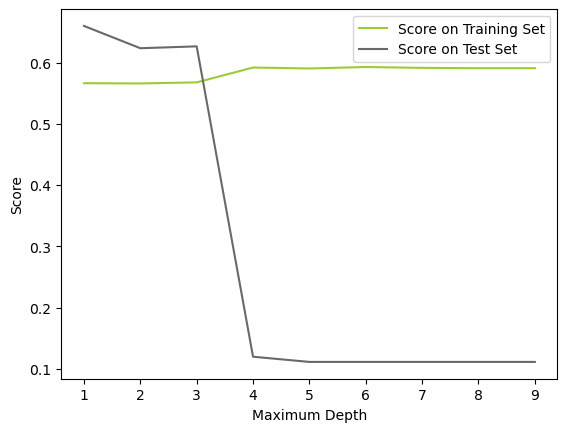

In [ ]:
plt.plot(list(range(1,10)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,10)), val_score_list, label="Score on Test Set", color='dimgray')
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

In [ ]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = label_encoder.fit_transform(df[col])